<a href="https://colab.research.google.com/github/alexsuakim/Computer-Vision/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You may need to run the following code to use SIFT (especially on google colab)
#!pip install opencv-contrib-python==4.5.5.62
#!pip install imutils
#!pip install mlxtend

     ---------------------------------------- 1.3/1.3 MB 4.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import imutils
import tarfile
import copy
import random
from pathlib import Path
from skimage.color import rgb2gray
from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.cluster import KMeans

**Q1**

(1) Capture a video from a webcam and apply the Lucas Kanade optical flow algorithm to track the corner points in the continuous frames.

In [ ]:
cap = cv2.VideoCapture('./video1.mp4')

# params for ShiTomasi corner detection
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15,15),
                 maxLevel=2,
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask=None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
while(1):
    ret, frame = cap.read()

    if ret == False:
        break
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0,None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new,good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        a, b, c, d = int(a), int(b), int(c), int(d)
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame, (a,b), 5, color[i].tolist(), -1)
    img = cv2.add(frame, mask)

    cv2.imshow('frame',img)
    k=cv2.waitKey(30) & 0xff
    if k == 27:
        break

# Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

(2) Write the Python code to obtain the dense optical flow of this video. (Hints: you may use Farneback algorithm to fulfil the requirement)

In [ ]:
cap = cv2.VideoCapture("https://viratdata.org/video/VIRAT_S_010204_05_000856_000890.mp4")
ret,frame1=cap.read()
prvs=cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

hsv=np.zeros_like(frame1)
hsv[...,1]=255
while(1):
    ret,frame2=cap.read()
    if ret == False:
        break

    next=cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow=cv2.calcOpticalFlowFarneback(prvs,next,None,0.5,3,15,3,5,1.2,0)
    mag,ang=cv2.cartToPolar(flow[...,0],flow[...,1])
    hsv[...,0]=ang*180/np.pi/2
    hsv[...,2]=cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    rgb=cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)
    cv2.imshow('frame2',rgb)
    k=cv2.waitKey(30)&0xff
    if k==27:
        break
    elif k==ord('s'):
        cv2.imwrite('opticalfb.png',frame2)
        cv2.imwrite('opticalhsv.png',rgb)
    prvs=next
cap.release()
cv2.destroyAllWindows()

**Q2 (1)**

i. Draw both corner and SIFT keypoints for each image that can describe conspicuous elements within the images which might be found in other images as well.

Text(0.5, 1.0, '2_3.png')

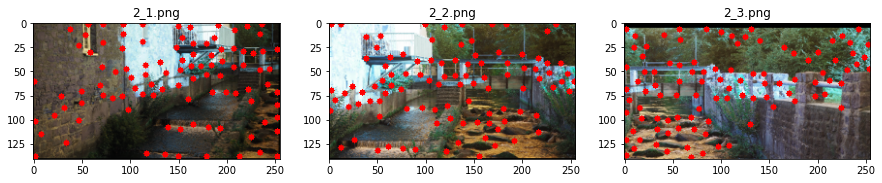

In [ ]:
#Corners
#read image
image1 = cv2.imread('./2_1.png')
image2 = cv2.imread('./2_2.png')
image3 = cv2.imread('./2_3.png')

#convert to greyscale
gray_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray_img3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)

#find corners with goodFeaturesToTrack function
corners1 = cv2.goodFeaturesToTrack(gray_img1, 100, 0.01, 10)
corners1 = np.int0(corners1)
corners2 = cv2.goodFeaturesToTrack(gray_img2, 100, 0.01, 10)
corners2 = np.int0(corners2)
corners3 = cv2.goodFeaturesToTrack(gray_img3, 100, 0.01, 10)
corners3 = np.int0(corners3)

#draw keypoints
for i in corners1:
    x, y = i.ravel()
    cv2.circle(image1, (x, y), 3, 255, -1)
for i in corners2:
    x, y = i.ravel()
    cv2.circle(image2, (x, y), 3, 255, -1)
for i in corners3:
    x, y = i.ravel()
    cv2.circle(image3, (x, y), 3, 255, -1)

#show images
fig, axes = plt.subplots(1,3, figsize=(15, 5))
#show first image
axes[0].imshow(image1)
axes[0].set_title("2_1.png")
#show second image
axes[1].imshow(image2)
axes[1].set_title("2_2.png")
#show third image
axes[2].imshow(image3)
axes[2].set_title("2_3.png")

Text(0.5, 1.0, '2_3.png')

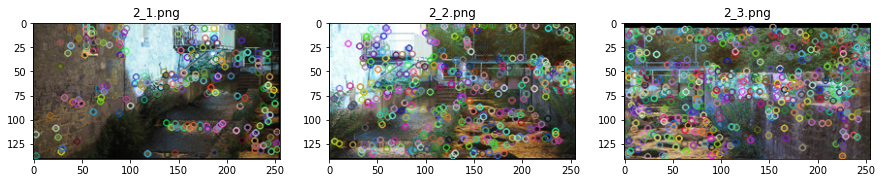

In [ ]:
#SIFT Keypoints
#read image
image1 = cv2.imread('./2_1.png')
image2 = cv2.imread('./2_2.png')
image3 = cv2.imread('./2_3.png')

#convert to greyscale
gray_img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
gray_img3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)

#apply sift feature extractor
sift = cv2.xfeatures2d.SIFT_create()
kps1, features1 = sift.detectAndCompute(gray_img1,None)
kps2, features2 = sift.detectAndCompute(gray_img2,None)
kps3, features3 = sift.detectAndCompute(gray_img3,None)

#draw keypoints
img_sift1 = cv2.drawKeypoints(image1,kps1,image1)
img_sift2 = cv2.drawKeypoints(image2,kps2,image2)
img_sift3 = cv2.drawKeypoints(image3,kps3,image3)

#show images
fig, axes = plt.subplots(1,3, figsize=(15, 5))
#show first image
axes[0].imshow(img_sift1)
axes[0].set_title("2_1.png")
#show second image
axes[1].imshow(img_sift2)
axes[1].set_title("2_2.png")
#show third image
axes[2].imshow(img_sift3)
axes[2].set_title("2_3.png")


ii.	Compare the keypoints you draw in (i) and explain whether they are suitable for stitching or not.

The Harris corner detection method is much more efficient in terms of time complexity. However, it's very difficult to get high correspondence of the points with Harris corner detection, especially if the images are scaled differently since corners could turn into edges when scaled differently. On the other hand, although SIFT feature detection method may take longer, it could be more suitable for images stitching with more robust and accurate results. SIFT is especially more robust when the scales of the images are different. Moreover, since SIFT features are local, it is known to be invariant to noise and illumination changes.

iii. Estimate the homography of the pairwise images based on the inliers, which can be calculated using the random sample consensus (RANSAC) method.

In [ ]:
def homography(kpsA, featuresA, kpsB, featuresB):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

    matches = []
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * 0.75:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) > 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[i].pt for (_, i) in matches])
        ptsB = np.float32([kpsB[i].pt for (i, _) in matches])

    # compute the homography between the two sets of points
    H, status = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, 4.0)
    return H, status, matches

print("homography for images 2_1 and 2_2 is:")
H12, status12, matches12 = homography(kps1, features1, kps2, features2)
print(H12)
print()
print("homography for images 2_2 and 2_3 is:")
H23, status23, matches23 = homography(kps2, features2, kps3, features3)
print(H23)



homography for images 2_1 and 2_2 is:
[[ 1.28429860e+00  1.77649467e-03 -1.49851139e+02]
 [ 3.43354445e-02  1.23363205e+00  2.31728578e+00]
 [ 4.66689075e-04  7.00734593e-05  1.00000000e+00]]

homography for images 2_2 and 2_3 is:
[[ 1.11029040e+00 -1.37055043e-05 -1.42382153e+02]
 [ 2.34027961e-02  1.06800443e+00  4.37079198e+00]
 [ 4.57917718e-04 -4.15053288e-05  1.00000000e+00]]


iv.	Plot the corresponding matches with the inliers.


Text(0.5, 1.0, '2_2 & 2_3 comparison')

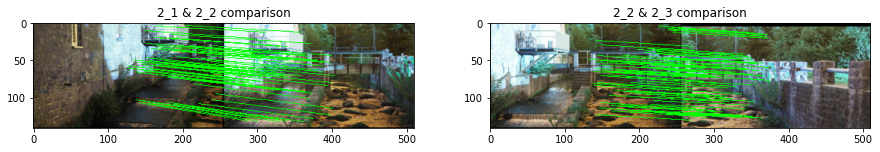

In [ ]:
def draw_lines(imageA, imageB, kpsA, kpsB, matches, status):

    # initialize the output image
    xA,yA = imageA.shape[:2]
    xB,yB = imageB.shape[:2]

    output = np.zeros((max(xA, xB), yA + yB, 3), dtype="uint8")
    output[0:xA, 0:yA] = imageA
    output[0:xB, yA:] = imageB

    for ((t,q), s) in zip(matches, status):
        if s==1:
            ptA = (int(kpsA[q].pt[0])), int(kpsA[q].pt[1])
            ptB = (int(kpsB[t].pt[0])) + yA, int(kpsB[t].pt[1])
            cv2.line(output, ptA, ptB, (0,255,0), 1)

    return output

image1 = cv2.imread('./2_1.png')
image2 = cv2.imread('./2_2.png')
image3 = cv2.imread('./2_3.png')

match12 = draw_lines(image1, image2, kps1, kps2, matches12, status12)
match23 = draw_lines(image2, image3, kps2, kps3, matches23, status23)
#show images
fig, axes = plt.subplots(1,2, figsize=(15, 5))
#show averaging filter
axes[0].imshow(match12)
axes[0].set_title("2_1 & 2_2 comparison")
#show gaussian filter
axes[1].imshow(match23)
axes[1].set_title("2_2 & 2_3 comparison")

**Q3 (1)**

i.

this is an example of a loaded image


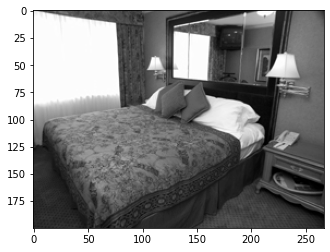

In [ ]:
#load images into lists
def load_images(directory):
    images = []
    img_class = []
    #there are 15 categories of pictures
    categories = [d for d in directory.iterdir()]
    #iterate categories and images and store images in a list in grayscale
    for i, categ in enumerate(categories):
        for file in categ.iterdir():
            img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
            images.append(img)
            img_class.append(i)

    return images, img_class

#path for training set
train_path = r'C:\Users\Sua\Desktop\STAT3010\a2\a2\Q3\data\train'
train_dir = Path(train_path)

#path for testing set
test_path = r'C:\Users\Sua\Desktop\STAT3010\a2\a2\Q3\data\test'
test_dir = Path(test_path)

#classes of categories
categories = [directory.name for directory in train_dir.iterdir()]
#number of classes/categories
n_classes = len(categories)

#load images and store them into arrays
train_img, Y_train = load_images(train_dir)
test_img, Y_test = load_images(test_dir)

#print the outcome
print("this is an example of a loaded image")
plt.imshow(train_img[0], cmap='gray')

there are 1500 training samples in 15 categories, and each sample is of size (16, 16)
this is an example of a tiny image:


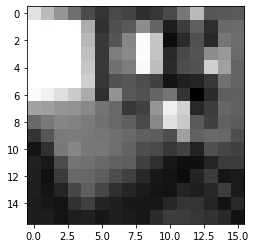

In [ ]:
#convert images to pixel size 16*16
def tiny_image(img):
    dim = (16,16)
    #reduce the size of images
    reduced = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #normalise to have zero mean and unit vector
    normalised = cv2.normalize(reduced, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return normalised

#apply the tiny_image function and store in a list
tiny_train = []
for img in train_img:
    tiny_train.append(tiny_image(img))
tiny_test = []
for img in test_img:
    tiny_test.append(tiny_image(img))

#print the outcome
print(f'there are {len(tiny_train)} training samples in {n_classes} categories, and each sample is of size {tiny_train[0].shape}')
print("this is an example of a tiny image:")
plt.imshow(tiny_train[0], cmap='gray')

#flatten the images to become features
X_train = np.reshape(tiny_train, (len(tiny_train), -1))
X_test = np.reshape(tiny_test, (len(tiny_test), -1))

ii.

In [ ]:
#apply knn classification with 100 neighbors and l2 distance
knn_model = KNeighborsClassifier(n_neighbors = n_classes * 10, metric = 'l2')
#train the classifier with training samples
knn_model.fit(X_train, Y_train)
#test the model with testing samples
Y_pred = knn_model.predict(X_test)

#print out the accuracy of the predictions
print(accuracy_score(Y_test, Y_pred))


0.21407035175879396


iii.

Describe what should be the performance limit of “tiny image” strategy, and explain why such a representation cannot capture the full feature of the original one.

The performance of tiny image classification turned out to be 0.214, which is about 3 times better than random guessing(0.067). Although it is better than random guessing, the performance is still not the best since it cannot capture the full features. The tiny image strategy merely compares the difference of pixel intensity in the same pixel locations. Through this method, the difference between pixel intensity can turn out great even if they are the same picture shifted. Merely calculating the distance between the pixel intensities of two pictures in the same pixel location is not as effective as feature extraction with SIFT.

**Q3 (2)**

i.

In [ ]:
# compute sift with a 4 pixel-stride
def dense_sift(image_set):
    sift = cv2.xfeatures2d.SIFT_create()
    sift_features = []
    step_size = 15 #changed step size from 4 to 20 because the runtime took too long
    for img in image_set:
        kp = [cv2.KeyPoint(x, y, step_size) for x in range(0, img.shape[0], step_size)
                                            for y in range(0, img.shape[1], step_size)]
        kp, des = sift.compute(img, kp)
        sift_features.append(des)
    return sift_features

# extract sift features from training and testing images
X_train = dense_sift(train_img)
X_test = dense_sift(test_img)

#transform X_train into an np array
descriptors = []
for i in range(len(X_train)):
    for j in range(X_train[i].shape[0]):
        descriptors.append(X_train[i][j,:])
descriptors = np.array(descriptors)

In [ ]:
#create histogram based on the feature vocabulary
def histogram(image_set, kmeans, k):
    hist = []
    for img in image_set:
        data = copy.deepcopy(img)
        pred = kmeans.predict(data)
        hist.append(np.bincount(pred, minlength=k).reshape(1,-1).ravel())
    return np.array(hist)

In [ ]:
#clustering
k=50
kmeans = KMeans(n_clusters=k).fit(descriptors)

#compute histograms for training images
train_hist = histogram(X_train, kmeans, k)
scaler = preprocessing.StandardScaler().fit(train_hist)
train_hist = scaler.transform(train_hist)

#compute histograms for testing images
test_hist = histogram(X_test, kmeans, k)
test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance

In [ ]:
#knn classification
knn = KNeighborsClassifier(n_neighbors=k, p=2)
knn.fit(train_hist, Y_train)
Y_pred = knn.predict(test_hist)

#compute accuracy
accuracy = accuracy_score(Y_test, Y_pred)

print(f'accuracy for k = {k}: {accuracy}')

accuracy for k = 50: 0.5989949748743718


ii.

In [ ]:
for k in range(10,45,5):
    #clustering
    kmeans = KMeans(n_clusters=k).fit(descriptors)

    #compute histograms for training images
    train_hist = histogram(X_train, kmeans, k)
    scaler = preprocessing.StandardScaler().fit(train_hist)
    train_hist = scaler.transform(train_hist)

    #compute histograms for testing images
    test_hist = histogram(X_test, kmeans, k)
    test_hist = scaler.transform(test_hist) #normalise histogram to zero mean and unit variance

    #knn classification
    knn = KNeighborsClassifier(n_neighbors=k, p=2)
    knn.fit(train_hist, Y_train)
    Y_pred = knn.predict(test_hist)

    #compute accuracy
    accuracy = accuracy_score(Y_test, Y_pred)

    print(f'accuracy for k = {k}: {accuracy}')

accuracy for k = 10: 0.4482412060301508
accuracy for k = 15: 0.5202680067001675
accuracy for k = 20: 0.5366834170854271
accuracy for k = 25: 0.5695142378559463
accuracy for k = 30: 0.5705192629815745
accuracy for k = 35: 0.5825795644891122
accuracy for k = 40: 0.5644891122278057


The accuracy seems to be the highest when k=35. With KNN and SIFT combines, the accuracy amounts to 0.58, which is much higher than the tiny image classification. Unlike the tiny image method that compares the intensity of each pixel, the SIFT method compares the detected features and their distribution histograms.